# Семинар 12: Ансамбль моделей: смешивание (blending) моделей, стэкинг (stacking) моделей

<img src="figures/ensemble_methods.png" style="height: 300px;"/>

In [6]:
import numpy as np

import sklearn
import sys
import os

np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib        as mpl
mpl.rc('axes' , labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [7]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
X.shape

(1797, 64)

(-0.5, 79.5, 79.5, -0.5)

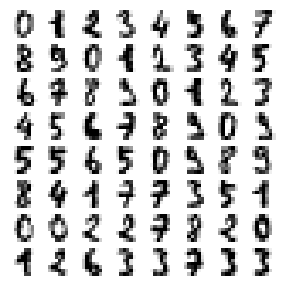

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_img_per_row = 8
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

ax.imshow(img, cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

In [11]:
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test .shape)

(1437, 64)
(360, 64)


## Повторние: бэггинг моделей в задаче классификации

In [15]:
rf_cls = RandomForestClassifier(n_estimators=100)
rf_cls.fit(X_train,y_train)

RandomForestClassifier()

In [16]:
y_pred = rf_cls.predict(X_test)
print("Classification Report")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Report")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        33
           1     0.9333    1.0000    0.9655        28
           2     1.0000    1.0000    1.0000        33
           3     1.0000    1.0000    1.0000        34
           4     1.0000    1.0000    1.0000        46
           5     0.9583    0.9787    0.9684        47
           6     0.9714    0.9714    0.9714        35
           7     0.9706    0.9706    0.9706        34
           8     1.0000    0.9333    0.9655        30
           9     0.9744    0.9500    0.9620        40

    accuracy                         0.9806       360
   macro avg     0.9808    0.9804    0.9803       360
weighted avg     0.9810    0.9806    0.9805       360

Confusion Report
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0

## Повторение: бустинг моделей в задаче классификации

In [27]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X)

X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test )

- eta (learning rate) : Уменьшение размера шага используется при обновлении для предотвращения переобучения модели.
- max_depth           : Максимальная глубина дерева. Увеличение этого значения приводит к усложнению модели и увеличению вероятности переобучения модели.
- gamma               : Минимальное уменьшение потерь, необходимое для выполнения дальнейшего разбиения на листовом узле дерева.
- subsample           : Коэффициент подвыборки тренировочных примеров. Установка этого значения в 0.5 означает, что перед выращиванием деревьев XGBoost будет производить случайную выборку половины обучающих данных, что позволит избежать переобучения. Операция будет производиться один раз на каждой итерации бустинга.
- colsample_bytree, colsample_bylevel, colsample_bynode : Параметры имеют диапазон (0, 1], значение по умолчанию равно 1, и задают долю столбцов, по которым будет производиться подвыборка.

- lambda : Коэффициент регуляризации L2
- alpha  : Коэффициент регуляризации L1

In [29]:
import xgboost as xgb

param_list = [("eta", 0.08), ("max_depth", 6), ("subsample", 0.8), ("colsample_bytree", 0.8), ("objective", "multi:softmax"), ("eval_metric", "merror"), ("alpha", 8), ("lambda", 2), ("num_class", 10)]
n_rounds       = 600
early_stopping = 50
    
d_train   = xgb.DMatrix(X_train_std, label=y_train)
d_test    = xgb.DMatrix(X_test_std , label=y_test )
eval_list = [(d_train, "train"), (d_test, "validation")]
bst = xgb.train(param_list, d_train, n_rounds, evals=eval_list, early_stopping_rounds=early_stopping, verbose_eval=True)

[0]	train-merror:0.12665	validation-merror:0.16389
[1]	train-merror:0.09116	validation-merror:0.11667
[2]	train-merror:0.06889	validation-merror:0.11389
[3]	train-merror:0.06054	validation-merror:0.10000
[4]	train-merror:0.05428	validation-merror:0.08611
[5]	train-merror:0.05358	validation-merror:0.08611
[6]	train-merror:0.05219	validation-merror:0.08889
[7]	train-merror:0.05150	validation-merror:0.08611
[8]	train-merror:0.05080	validation-merror:0.09167
[9]	train-merror:0.05150	validation-merror:0.08611
[10]	train-merror:0.05010	validation-merror:0.08889
[11]	train-merror:0.04732	validation-merror:0.09167
[12]	train-merror:0.04593	validation-merror:0.08889
[13]	train-merror:0.04662	validation-merror:0.08889
[14]	train-merror:0.04732	validation-merror:0.09167
[15]	train-merror:0.04662	validation-merror:0.08889
[16]	train-merror:0.04384	validation-merror:0.08333
[17]	train-merror:0.04315	validation-merror:0.08056
[18]	train-merror:0.04175	validation-merror:0.07778
[19]	train-merror:0.04

In [31]:
y_pred = bst.predict(d_test)

print("Classification Report")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Report")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0     1.0000    0.9697    0.9846        33
           1     0.8966    0.9286    0.9123        28
           2     1.0000    1.0000    1.0000        33
           3     1.0000    0.9412    0.9697        34
           4     0.9773    0.9348    0.9556        46
           5     0.9565    0.9362    0.9462        47
           6     0.9444    0.9714    0.9577        35
           7     0.9167    0.9706    0.9429        34
           8     0.9032    0.9333    0.9180        30
           9     0.8780    0.9000    0.8889        40

    accuracy                         0.9472       360
   macro avg     0.9473    0.9486    0.9476       360
weighted avg     0.9485    0.9472    0.9475       360

Confusion Report
[[32  0  0  0  1  0  0  0  0  0]
 [ 0 26  0  0  0  0  0  0  0  2]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 32  0  1  0  0  1  0]
 [ 0  1  0  0 43  0  1  1  0  0]
 [ 0  0  0  0  0 44  1  0  0  2]
 [ 0

## Смешивание моделей (Blending models)

<img src="figures/blending.png" style="height: 500px;"/>

- Разделите обучающие данные на две части: обучающий и проверочный наборы.
- Обучить каждую базовую модель на обучающем наборе.
- Сделать прогнозы с использованием базовых моделей на валидационном множестве и новых, неизвестных данных.
- Объединить эти прогнозы с помощью заданной функции смешивания или метода агрегирования (например, средневзвешенного, большинства голосов) для получения окончательного результата.

### Голосование в задаче классификации (Voting Classifiers)

In [32]:
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm          import SVC

#### Hard голосование

При `hard` голосовании прогнозируемым выходным классом является класс с наибольшим большинством голосов, т.е. тот класс, который с наибольшей вероятностью был предсказан каждым из классификаторов. Предположим, три классификатора предсказали выходной класс (A, A, B), и здесь большинство предсказало A в качестве выходного. Следовательно, окончательным прогнозом будет A.

#### Soft голосование

При `soft` голосовании выходным классом является предсказание, основанное на среднем значении вероятности, присвоенной этому классу. Предположим, что на вход трех моделей поданы вероятности предсказания для класса A = (0,30, 0,47, 0,53) и B = (0,20, 0,32, 0,40). Таким образом, среднее значение для класса A равно 0,4333, а для B - 0,3067, и победителем явно становится класс A, поскольку он имеет наибольшую вероятность, усредненную по каждому классификатору.


In [67]:
log_clf = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", max_iter=1000, random_state=42)

voting_clf = VotingClassifier( estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

In [68]:
voting_clf.fit(X_train_std, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=2000,
                                                 random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(max_iter=1000, random_state=42))])

In [69]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.9722222222222222
RandomForestClassifier 0.9722222222222222
SVC 0.9861111111111112


/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.9805555555555555


In [70]:
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier( estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [71]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.9722222222222222
RandomForestClassifier 0.9722222222222222
SVC 0.9861111111111112


/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.9805555555555555


In [72]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf   = ExtraTreesClassifier  (n_estimators=100, random_state=42)
svm_clf           = LinearSVC             (max_iter=200, tol=20, random_state=42)
mlp_clf           = MLPClassifier         (random_state=42)

In [73]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf"  , extra_trees_clf  ),
    ("svm_clf"          , svm_clf          ),
    ("mlp_clf"          , mlp_clf          ),
]

In [74]:
voting_clf = VotingClassifier(named_estimators)

In [78]:
voting_clf.fit(X_train_std, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=200, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [79]:
voting_clf.score(X_test_std, y_test)

0.9805555555555555

In [81]:
[estimator.score(X_test_std, y_test) for estimator in voting_clf.estimators_]

[0.9722222222222222,
 0.9805555555555555,
 0.9388888888888889,
 0.9805555555555555]

Давайте удалим SVM и посмотрим, улучшится ли качество модели. Удалить можно, установив для него значение `None` с помощью `set_params()`, например, так:

In [83]:
voting_clf.set_params(svm_clf=None)
del voting_clf.estimators_[2]

Теперь снова оценим `VotingClassifier`

In [85]:
voting_clf.voting = "hard"
voting_clf.score(X_test_std, y_test)

0.9805555555555555

Немного лучше! SVM ухудшала производительность. Теперь попробуем использовать классификатор с мягким голосованием. На самом деле нам не нужно переобучать классификатор, мы можем просто установить `voting` в значение `"soft"`

In [86]:
voting_clf.voting = "soft"
voting_clf.score(X_test_std, y_test)

0.9861111111111112

## Стэкинг моделей

<img src="figures/stacking.png" style="height: 500px;"/>

- Разделить обучающие данные на K порций (например, с помощью K-кратной перекрестной валидации).
- Обучить каждую базовую модель на K-1 порции данныз и выполнить прогноз на оставшихся порциях данных.
- Повторить этот процесс для всех K порций данных, в результате чего для каждой базовой модели будет получен набор мета-прогнозов.
- Объединив их, создайть новый набор данных, который будет использоваться в качестве входных признаков для мета-модели.
- Обучить мета-модель на этом новом наборе данных с исходной целевой переменной в качестве выходного параметра.
- Чтобы сделать прогноз на новых, неизвестных данных, пропустите их через базовые модели для получения прогнозов, а затем используйте эти прогнозы в качестве входных признаков для мета-модели.

In [87]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf   = ExtraTreesClassifier  (n_estimators=100, random_state=42)
svm_clf           = LinearSVC             (max_iter=200, tol=20, random_state=42)
mlp_clf           = MLPClassifier         (random_state=42)

In [88]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train_std, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=200, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [89]:
[estimator.score(X_test_std, y_test) for estimator in estimators]

[0.9722222222222222,
 0.9805555555555555,
 0.9388888888888889,
 0.9805555555555555]

In [90]:
from sklearn.ensemble import StackingClassifier

In [91]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf"  , extra_trees_clf  ),
    ("svm_clf"          , svm_clf          ),
    ("mlp_clf"          , mlp_clf          ),
]

In [101]:
stacked_clf = StackingClassifier(estimators=named_estimators, final_estimator=LogisticRegression(max_iter=1000))

In [102]:
stacked_clf.fit(X_train_std, y_train)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [103]:
stacked_clf.score(X_test_std, y_test)

0.9861111111111112

In [104]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf"  , extra_trees_clf  ),
    ("mlp_clf"          , mlp_clf          ),
]

In [105]:
stacked_clf = StackingClassifier(estimators=named_estimators, final_estimator=LogisticRegression())

In [106]:
stacked_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [107]:
stacked_clf.score(X_test, y_test)

0.9861111111111112